In [33]:
import os
import sys
sys.path.append(os.getcwd()+"/../..")
from src import paths

from src.utils import (
                        line_label_id2label, 
                        line_label_label2id, 
                        line_label_token_id2label, 
                        plot_embeddings, 
                        get_df_classificationreport,
                        pretty_confusion_matrix,
)

import pandas as pd

import torch

In [32]:
import importlib
import src.utils
importlib.reload(src.utils)

<module 'src.utils' from '/cluster/home/eglimar/inf-extr/notebooks/line-label_prediction/../../src/utils.py'>

# MedBERT Finetune on Lines

In [34]:
results = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_test.pt")
y_true = results["labels"]
last_hidden_state = results["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
y_pred = results["preds"]

In [35]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

In [36]:
display_labels = {k:v.replace("_", "/") for k,v in line_label_id2label.items()}

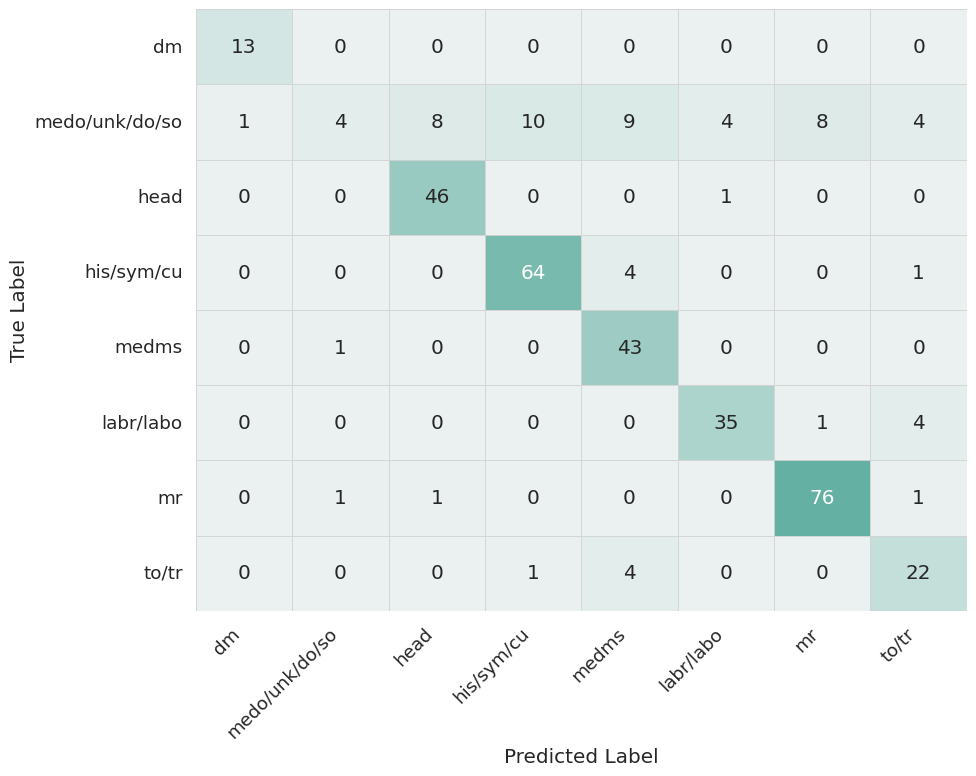

In [37]:
pretty_confusion_matrix(y_true, y_pred, display_labels)

In [38]:
y_valid = [line_label_id2label[label] for label in y_true]
y_pred = [line_label_id2label[pred] for pred in y_pred]
get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.84,0.98,0.90,47
2,his_sym_cu,0.85,0.93,0.89,69
3,labr_labo,0.88,0.88,0.88,40
4,medms,0.72,0.98,0.83,44
5,medo_unk_do_so,0.67,0.08,0.15,48
6,mr,0.89,0.96,0.93,79
7,to_tr,0.69,0.81,0.75,27
8,accuracy,NaN,NaN,0.83,367
9,macro avg,0.81,0.83,0.78,367


In [39]:
print("Accuracy: ", (pd.Series(y_valid) == pd.Series(y_pred)).mean())

Accuracy:  0.8256130790190735


(367, 2)


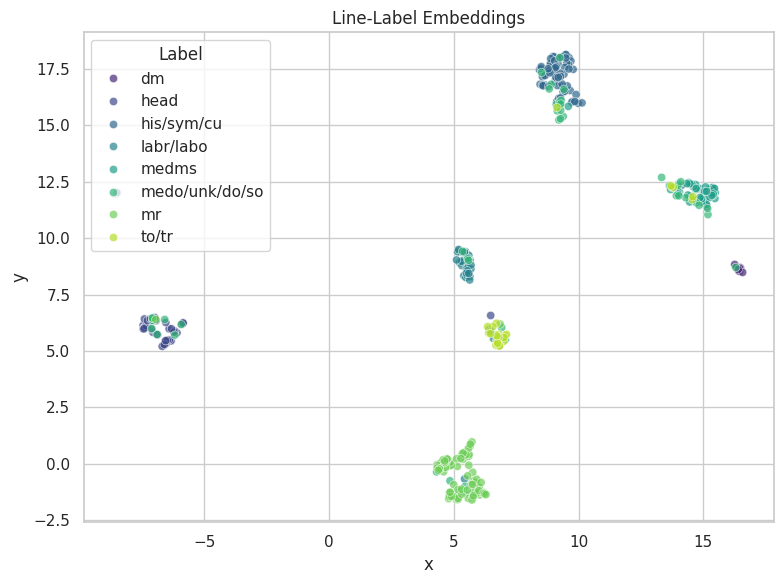

In [40]:
plot_embeddings(embeddings, [line_label_id2label[label].replace("_", "/") for label in y_true], title="Line-Label Embeddings", method="umap", )

In [9]:
# Analysis of FP and TP
# results.pop("last_hidden_state")
# results_df = pd.DataFrame(results)
# results_df.replace(line_label_id2label, inplace = True)

In [10]:
# pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_colwidth', None)
# results_df[results_df["preds"] != results_df["labels"]]

In [11]:
# results_df[results_df["labels"] == "head"]

# MedBERT Token Classification

In [41]:
results = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test.pt")

In [42]:
labels, preds = [], []
for obs in results:
    labels.extend(obs["labs"])
    preds.extend(obs["preds"])
y_true = [line_label_label2id[label] for label in labels]
y_pred = [line_label_label2id[pred] for pred in preds]


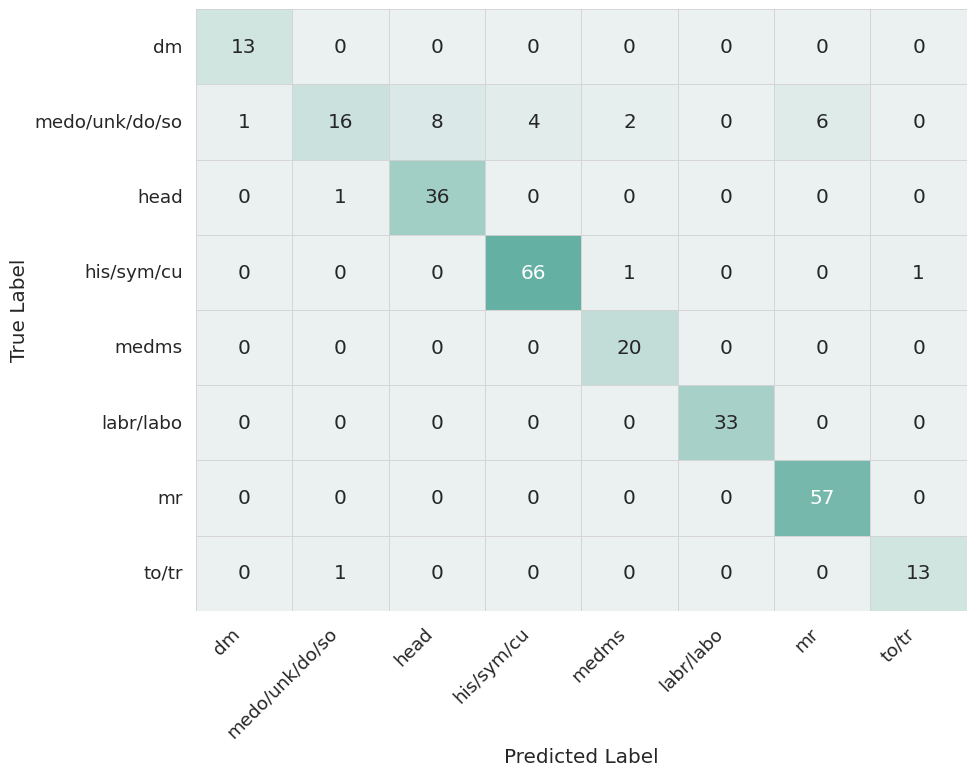

In [55]:
pretty_confusion_matrix(y_true, y_pred, display_labels, save_dir = paths.THESIS_PATH/"line-label_token_cm.png")

In [54]:
token_results = get_df_classificationreport(labels, preds, labels = sorted(line_label_id2label.values())).round(2)
token_results.to_csv(paths.THESIS_PATH/"line-label_token_results.csv")
token_results

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.82,0.97,0.89,37
2,his_sym_cu,0.94,0.97,0.96,68
3,labr_labo,1.00,1.00,1.00,33
4,medms,0.87,1.00,0.93,20
5,medo_unk_do_so,0.89,0.43,0.58,37
6,mr,0.90,1.00,0.95,57
7,to_tr,0.93,0.93,0.93,14
8,accuracy,NaN,NaN,0.91,279
9,macro avg,0.91,0.91,0.90,279


In [45]:
print("Accuracy: ", (pd.Series(y_true) == pd.Series(y_pred)).mean())

Accuracy:  0.910394265232975


In [46]:
# Hidden States
last_hidden_state = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test_hidden_states.pt")

# Only plot B-labels
b_labels = [label for label in last_hidden_state["labels"] if label in list(range(8))]
b_labels = [line_label_token_id2label[label].replace("_", "/") for label in b_labels]
b_label_idx = [i for i, label in enumerate(last_hidden_state["labels"]) if label in list(range(8))]
b_hidden_states = last_hidden_state["last_hidden_states"][b_label_idx]

(288, 2)


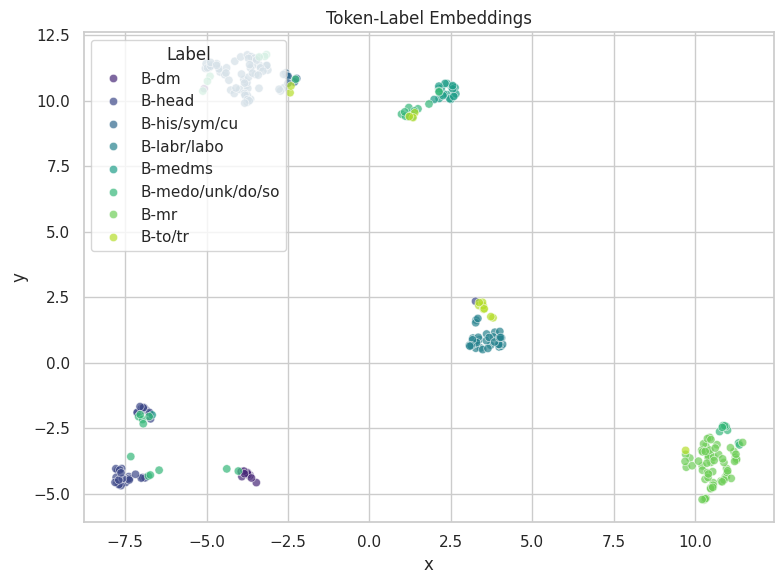

In [47]:
plot_embeddings(b_hidden_states, b_labels, title="Token-Label Embeddings", method="umap", save_dir = paths.THESIS_PATH/"line-label_token_embeddings.png")

# Comparing Both models
Need to truncate the outputs of line classifier too

In [56]:
res_line = torch.load(paths.RESULTS_PATH/"line-label"/"line-label_medbert-512_class_test.pt")
res_token = torch.load(paths.RESULTS_PATH/"line-label/line-label_medbert-512_token_test.pt")

In [57]:
res_line_rids = pd.DataFrame(res_line["rid"], columns = ["rid"])

In [58]:
indexes = []
lengths = 0
for rid, data in res_line_rids.groupby("rid"):
    # Find corresponding token obs
    for obs in res_token:
        if obs["rid"] == rid:
            length = len(obs["labs"])
            break
    # Select the indexes up to the length of the token obs
    indexes.extend(list(data.index)[:length])

In [59]:
res_line_df = pd.DataFrame(res_line, columns=res_line.keys())
res_line_df = res_line_df.loc[indexes]

In [60]:
y_true = res_line_df["labels"]
last_hidden_state = res_line_df["last_hidden_state"] # If inference was run without --output_hidden_states, this will be None and no plottings will be possible
y_pred = res_line_df["preds"]

In [61]:
# Last hidden stats is list of tensors, each tensor is (seq_len, hidden_size). Will take CLS token
cls_tokens = [tensor[0,:] for tensor in last_hidden_state]

embeddings = torch.stack(cls_tokens, dim = 0)

In [62]:
display_labels = {k:v.replace("_", "/") for k,v in line_label_id2label.items()}

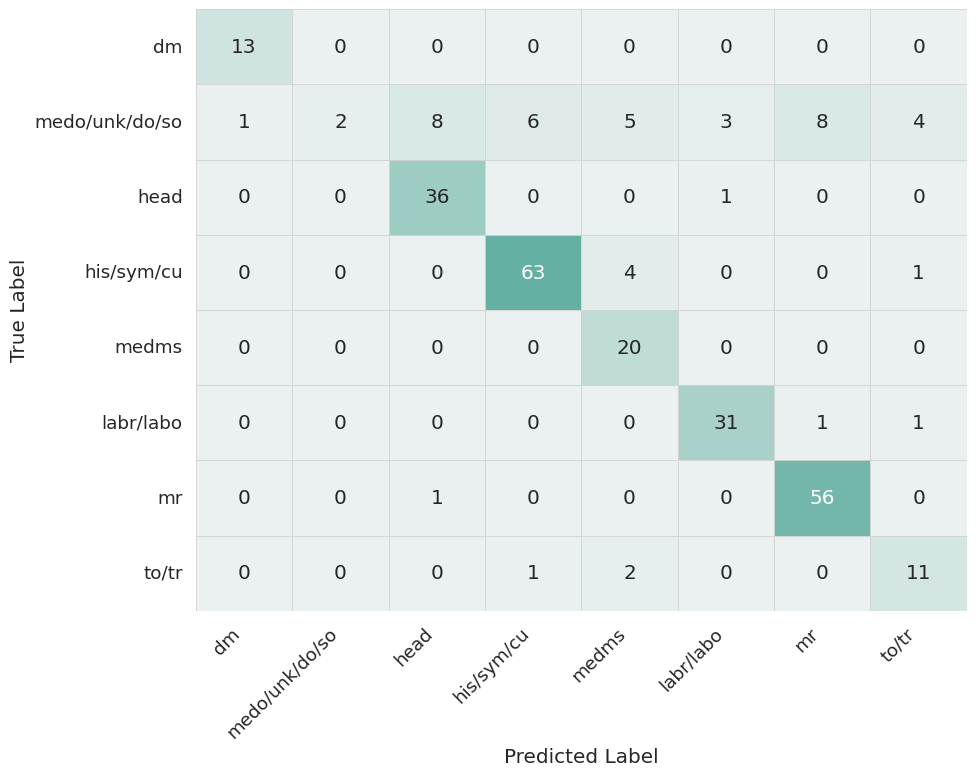

In [63]:
pretty_confusion_matrix(y_true, y_pred, display_labels, save_dir = paths.THESIS_PATH/"line-label_line_cm.png")

In [64]:
y_valid = [line_label_id2label[label] for label in y_true]
y_pred = [line_label_id2label[pred] for pred in y_pred]
line_results = get_df_classificationreport(y_valid, y_pred, labels = sorted(line_label_id2label.values())).round(2)
line_results.to_csv(paths.THESIS_PATH/"line-label_line_results.csv")
line_results

,eval_measure,precision,recall,f1-score,support
0,dm,0.93,1.00,0.96,13
1,head,0.80,0.97,0.88,37
2,his_sym_cu,0.90,0.93,0.91,68
3,labr_labo,0.89,0.94,0.91,33
4,medms,0.65,1.00,0.78,20
5,medo_unk_do_so,1.00,0.05,0.10,37
6,mr,0.86,0.98,0.92,57
7,to_tr,0.65,0.79,0.71,14
8,accuracy,NaN,NaN,0.83,279
9,macro avg,0.83,0.83,0.77,279


In [65]:
print("Accuracy: ", (pd.Series(y_valid) == pd.Series(y_pred)).mean())

Accuracy:  0.8315412186379928


(279, 2)


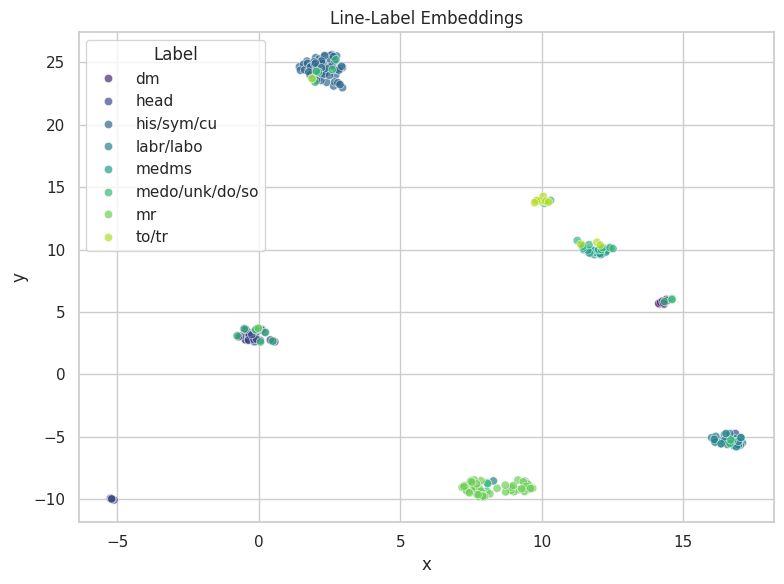

In [66]:
plot_embeddings(embeddings, [line_label_id2label[label].replace("_", "/") for label in y_true], title="Line-Label Embeddings", method="umap", save_dir = paths.THESIS_PATH/"line-label_line_embeddings.png")

In [30]:
print(pd.concat([line_results.iloc[:, :-1], token_results.iloc[:, 1:-1]], axis = 1).to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
eval_measure & precision & recall & f1-score & precision & recall & f1-score \\
\midrule
dm & 0.93 & 1.00 & 0.96 & 0.93 & 1.00 & 0.96 \\
head & 0.80 & 0.97 & 0.88 & 0.82 & 0.97 & 0.89 \\
his_sym_cu & 0.90 & 0.93 & 0.91 & 0.94 & 0.97 & 0.96 \\
labr_labo & 0.89 & 0.94 & 0.91 & 1.00 & 1.00 & 1.00 \\
medms & 0.65 & 1.00 & 0.78 & 0.87 & 1.00 & 0.93 \\
medo_unk_do_so & 1.00 & 0.05 & 0.10 & 0.89 & 0.43 & 0.58 \\
mr & 0.86 & 0.98 & 0.92 & 0.90 & 1.00 & 0.95 \\
to_tr & 0.65 & 0.79 & 0.71 & 0.93 & 0.93 & 0.93 \\
accuracy & NaN & NaN & 0.83 & NaN & NaN & 0.91 \\
macro avg & 0.83 & 0.83 & 0.77 & 0.91 & 0.91 & 0.90 \\
weighted avg & 0.86 & 0.83 & 0.78 & 0.91 & 0.91 & 0.90 \\
custom_weighted & 0.83 & 0.98 & 0.89 & 0.91 & 0.99 & 0.95 \\
\bottomrule
\end{tabular}

